### 가장 성능이 좋았던 Z-score standardization을 BASE에만 적용하자


In [16]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [17]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'
bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [18]:
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [28]:
import cv2

def apply_zscore_normalization_based_on_base(img_array, mean_base, std_base):
    """Apply Z-Score normalization to the image based on the provided mean and standard deviation."""
    return (img_array - mean_base) / std_base

# Calculate mean and standard deviation for the base image
Base_img = np.array(Image.open(bot_path_list[0]))
mean_base = np.mean(Base_img)
std_base = np.std(Base_img)

Top_transformed_list_zscore_base = []

for i in range(len(bot_path_list)):
    bot_img = np.array(Image.open(bot_path_list[i]))
    top_img = np.array(Image.open(top_path_list[i]))
    
    # Z-Score Normalization based on base image
    top_img_zscore_base = apply_zscore_normalization_based_on_base(top_img, mean_base, std_base)
    Top_transformed_list_zscore_base.append(top_img_zscore_base)


### AutoML 먼저 시도

In [29]:
top_avg_rgb_zscore_base = []
    
for i in range(len(Top_transformed_list_zscore_base)):
    top = Top_transformed_list_zscore_base[i]
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb_zscore_base.append([Top_R, Top_G, Top_B])

In [30]:
top_avg_rgb_zscore_base = np.array(top_avg_rgb_zscore_base)

In [31]:
Table_dataset_zscore_base = pd.DataFrame(np.concatenate([top_avg_rgb_zscore_base, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])

In [32]:
from tpot import TPOTRegressor

X_train_zscore_base, X_test_zscore_base, y_train_zscore_base, y_test_zscore_base = train_test_split(Table_dataset_zscore_base.iloc[:,:-1], Table_dataset_zscore_base.iloc[:,-1], test_size=0.3, random_state=42)
tpot_zscore_base = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot_zscore_base.fit(X_train_zscore_base, y_train_zscore_base)
tpot_zscore_base.export('tpot_corrected_zscore_base.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -42.686667083184616

Generation 2 - Current best internal CV score: -41.735812239537964

Generation 3 - Current best internal CV score: -41.735812239537964

Generation 4 - Current best internal CV score: -41.735812239537964

Generation 5 - Current best internal CV score: -41.042470780085125

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=4, p=2, weights=distance)


In [33]:
y_pred_zscore_base = tpot_zscore_base.predict(X_test_zscore_base)

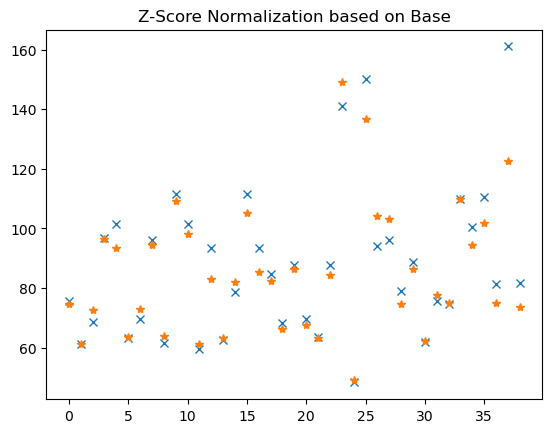

In [34]:
plt.title('Z-Score Normalization based on Base')
plt.plot(y_test_zscore_base.values,'x', label = 'True')
plt.plot(y_pred_zscore_base,'*', label = 'Predict')

In [35]:
zscore_based_result = pd.DataFrame({'True': y_test_zscore_base.values, 'Predict': y_pred_zscore_base})

zscore_based_result.to_csv('./data/zscore_based_result.csv', index=False)

In [36]:
zscore_based_mse = np.mean((y_test_zscore_base.values - y_pred_zscore_base)**2)
print('MSE: ', zscore_based_mse)

MSE:  64.03884876819937
